# Example application of ORD datasets for downstream machine learning modeling

Reproducing neural network predictor of reaction yields from Granda et al. Nature 2018, 559, 377, DOI: 10.1038/s41586-018-0307-8.<br>
Data from Perera et al. Science 2018, 359, 429, DOI: 10.1126/science.aap9112.<br>
ORD dataset location: https://github.com/open-reaction-database/ord-data/tree/main/data/68<br>
ORD dataset ID: ord_dataset-68cb8b4b2b384e3d85b5b1efae58b203

In [19]:
# Import packages
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wget

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from glob import glob

In [3]:
# Download data from ord-data pull request and load to Dataset message
url = 'https://github.com/open-reaction-database/ord-data/blob/main/data/68/ord_dataset-68cb8b4b2b384e3d85b5b1efae58b203.pb.gz?raw=true'

# Check if .pb.gz has already been downloaded
suffixes = ('.pb.gz', '.pb', '.pbtxt.gz', '.pbtxt')
pbs = [pb for pb in glob(os.getcwd()+'/*') if pb.endswith(suffixes)]
if len(pbs) > 0:
    pb = pbs[0]
else:
    pb = wget.download(url)

# Load dataset message
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

In [4]:
# Ensure dataset validates
valid_output = validations.validate_message(data)

# Check errors
valid_output.errors

[]

In [5]:
# Convert dataset to pandas dataframe
df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)

# View dataframe
df

,"inputs[""Solvent_1""].components[0].identifiers[0].value","inputs[""Boronate in Solvent""].components[0].identifiers[0].value","inputs[""Boronate in Solvent""].components[1].identifiers[0].value","inputs[""Ligand in Solvent""].components[0].identifiers[0].value","inputs[""Ligand in Solvent""].components[0].amount.moles.value","inputs[""Ligand in Solvent""].components[0].amount.moles.units","inputs[""Ligand in Solvent""].components[0].reaction_role","inputs[""Ligand in Solvent""].components[1].identifiers[0].type","inputs[""Ligand in Solvent""].components[1].identifiers[0].value","inputs[""Ligand in Solvent""].components[1].amount.volume.value",...,"inputs[""Base in Solvent""].components[1].reaction_role","inputs[""Aryl Halide""].components[0].identifiers[0].value",outcomes[0].products[0].measurements[0].percentage.value,provenance.record_modified[1].time.value,reaction_id,"inputs[""Ligand in Solvent""].components[0].amount.volume.value","inputs[""Ligand in Solvent""].components[0].amount.volume.units","inputs[""Ligand in Solvent""].components[0].amount.volume_includes_solutes","inputs[""Base in Solvent""].components[0].amount.volume.value","inputs[""Base in Solvent""].components[0].amount.volume.units"
0,CC#N,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,CN(C)C=O,CC(C)(C)P(C(C)(C)C)C(C)(C)C,0.05,MICROMOLE,CATALYST,SMILES,Cc1ccccc1,1.0,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,4.760000,2021-03-04 13:56:15.292871,ord-61b2819b15824f1fa131ed1b2ea1dae4,NaN,NaN,NaN,NaN,NaN
1,CC#N,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,CN(C)C=O,c1ccc(cc1)P(c2ccccc2)c3ccccc3,0.05,MICROMOLE,CATALYST,SMILES,Cc1ccccc1,1.0,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,4.120000,2021-03-04 13:56:15.298402,ord-f18c2b2d0bd04d2c96a3a16dfd8b8bef,NaN,NaN,NaN,NaN,NaN
2,CC#N,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,CN(C)C=O,CC(C)(C)P(C1=CC=C(C=C1)N(C)C)C(C)(C)C.CC(C)(C)...,0.05,MICROMOLE,CATALYST,SMILES,Cc1ccccc1,1.0,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,2.580000,2021-03-04 13:56:15.303978,ord-1061f43c594b4de68345c010b2aef94b,NaN,NaN,NaN,NaN,NaN
3,CC#N,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,CN(C)C=O,C1CCC(CC1)P(C2CCCCC2)C3CCCCC3,0.05,MICROMOLE,CATALYST,SMILES,Cc1ccccc1,1.0,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,4.440000,2021-03-04 13:56:15.309572,ord-e61614af430845179c392e478d958383,NaN,NaN,NaN,NaN,NaN
4,CC#N,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,CN(C)C=O,Cc1ccccc1P(c2ccccc2C)c3ccccc3C,0.05,MICROMOLE,CATALYST,SMILES,Cc1ccccc1,1.0,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,1.950000,2021-03-04 13:56:15.315080,ord-3fede496f4284a5ea6656f083e2399ae,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,CN(C)C=O,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,O=CN(C)C,CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.CC(C)...,0.05,MICROMOLE,CATALYST,SMILES,Cc1ccccc1,1.0,...,SOLVENT,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,47.209999,2021-03-04 13:56:49.737623,ord-b498385d41664713aaef79a290409614,NaN,NaN,NaN,NaN,NaN
5756,CN(C)C=O,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,O=CN(C)C,CC(C)c1cc(c(c(c1)C(C)C)c2ccccc2P(C3CCCCC3)C4CC...,0.05,MICROMOLE,CATALYST,SMILES,Cc1ccccc1,1.0,...,SOLVENT,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,0.000000,2021-03-04 13:56:49.743574,ord-2ef787f9faac4077bff2d903866aa209,NaN,NaN,NaN,NaN,NaN
5757,CN(C)C=O,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,O=CN(C)C,c1ccc(cc1)P([c-]2cccc2)c3ccccc3.c1ccc(cc1)P([c...,0.05,MICROMOLE,CATALYST,SMILES,Cc1ccccc1,1.0,...,SOLVENT,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,31.440001,2021-03-04 13:56:49.749090,ord-654740d21331471cafdfda41ff19d57a,NaN,NaN,NaN,NaN,NaN
5758,CN(C)C=O,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,O=CN(C)C,CC1(c2cccc(c2Oc3c1cccc3P(c4ccccc4)c5ccccc5)P(c...,0.05,MICROMOLE,CATALYST,SMILES,Cc1ccccc1,1.0,...,SOLVENT,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,0.000000,2021-03-04 13:56:49.754742,ord-8e53efc193e548ba888b47da3e91ced5,NaN,NaN,NaN,NaN,NaN


In [6]:
# View all columns with variation in the dataset
list(df.columns)

['inputs["Solvent_1"].components[0].identifiers[0].value',
 'inputs["Boronate in Solvent"].components[0].identifiers[0].value',
 'inputs["Boronate in Solvent"].components[1].identifiers[0].value',
 'inputs["Ligand in Solvent"].components[0].identifiers[0].value',
 'inputs["Ligand in Solvent"].components[0].amount.moles.value',
 'inputs["Ligand in Solvent"].components[0].amount.moles.units',
 'inputs["Ligand in Solvent"].components[0].reaction_role',
 'inputs["Ligand in Solvent"].components[1].identifiers[0].type',
 'inputs["Ligand in Solvent"].components[1].identifiers[0].value',
 'inputs["Ligand in Solvent"].components[1].amount.volume.value',
 'inputs["Ligand in Solvent"].components[1].amount.volume.units',
 'inputs["Ligand in Solvent"].components[1].amount.volume_includes_solutes',
 'inputs["Ligand in Solvent"].components[1].reaction_role',
 'inputs["Base in Solvent"].components[0].identifiers[0].value',
 'inputs["Base in Solvent"].components[0].amount.moles.value',
 'inputs["Base i

In [7]:
# Create new dataframe containing only columns to be used in modeling
model_cols = ['inputs["Aryl Halide"].components[0].identifiers[0].value',
              'inputs["Boronate in Solvent"].components[0].identifiers[0].value',
              'inputs["Ligand in Solvent"].components[0].identifiers[0].value',
              'inputs["Base in Solvent"].components[0].identifiers[0].value',
              'inputs["Solvent_1"].components[0].identifiers[0].value',
              'outcomes[0].products[0].measurements[0].percentage.value']
df = df[model_cols]
df

,"inputs[""Aryl Halide""].components[0].identifiers[0].value","inputs[""Boronate in Solvent""].components[0].identifiers[0].value","inputs[""Ligand in Solvent""].components[0].identifiers[0].value","inputs[""Base in Solvent""].components[0].identifiers[0].value","inputs[""Solvent_1""].components[0].identifiers[0].value",outcomes[0].products[0].measurements[0].percentage.value
0,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,CC(C)(C)P(C(C)(C)C)C(C)(C)C,[OH-].[Na+],CC#N,4.760000
1,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,c1ccc(cc1)P(c2ccccc2)c3ccccc3,[OH-].[Na+],CC#N,4.120000
2,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,CC(C)(C)P(C1=CC=C(C=C1)N(C)C)C(C)(C)C.CC(C)(C)...,[OH-].[Na+],CC#N,2.580000
3,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,C1CCC(CC1)P(C2CCCCC2)C3CCCCC3,[OH-].[Na+],CC#N,4.440000
4,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,Cc1ccccc1P(c2ccccc2C)c3ccccc3C,[OH-].[Na+],CC#N,1.950000
...,...,...,...,...,...,...
5755,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.CC(C)...,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],CN(C)C=O,47.209999
5756,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,CC(C)c1cc(c(c(c1)C(C)C)c2ccccc2P(C3CCCCC3)C4CC...,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],CN(C)C=O,0.000000
5757,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,c1ccc(cc1)P([c-]2cccc2)c3ccccc3.c1ccc(cc1)P([c...,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],CN(C)C=O,31.440001
5758,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,CC1(c2cccc(c2Oc3c1cccc3P(c4ccccc4)c5ccccc5)P(c...,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],CN(C)C=O,0.000000


In [8]:
# Check for NaN values
print(f'number of NaN values: {df.isnull().sum().sum()}')

# Show column counts
df.info()

number of NaN values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 6 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   inputs["Aryl Halide"].components[0].identifiers[0].value          5760 non-null   object 
 1   inputs["Boronate in Solvent"].components[0].identifiers[0].value  5760 non-null   object 
 2   inputs["Ligand in Solvent"].components[0].identifiers[0].value    5760 non-null   object 
 3   inputs["Base in Solvent"].components[0].identifiers[0].value      5760 non-null   object 
 4   inputs["Solvent_1"].components[0].identifiers[0].value            5760 non-null   object 
 5   outcomes[0].products[0].measurements[0].percentage.value          5760 non-null   float64
dtypes: float64(1), object(5)
memory usage: 270.1+ KB


In [9]:
# Show dataset statistics for numerical fields
df.describe()

,outcomes[0].products[0].measurements[0].percentage.value
count,5760.000000
mean,40.109446
std,28.081087
min,0.000000
25%,16.197501
50%,33.580000
75%,62.870001
max,100.000000


In [10]:
# Convert reaction input labels to one-hot encoding
input_cols = model_cols[:-1]

# Assign names for each input
prefix = ['electrophile',
          'nucleophile',
          'ligand',
          'base',
          'solvent']

# Create one-hot encoded input dataset
ohe_df = pd.get_dummies(df[input_cols], prefix=prefix)

# Add yield column to ohe dataset
ohe_df['yield'] = df[model_cols[-1]]/100

# Shuffle dataset
ohe_df = ohe_df.sample(frac=1)

# View dataset
ohe_df

,electrophile_BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,electrophile_BrC1=CC=C2N=CC=CC2=C1,electrophile_ClC1=CC=C2N=CC=CC2=C1,electrophile_IC1=CC=C2N=CC=CC2=C1,electrophile_O=S(OC1=CC=C2N=CC=CC2=C1)(C(F)(F)F)=O,nucleophile_B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,nucleophile_CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,nucleophile_Cc1ccc2n(C3CCCCO3)ncc2c1B4OC(C)(C)C(C)(C)O4,nucleophile_F[B-](F)(C1=C(C)C=CC2=C1C=NN2C3CCCCO3)F.[K+],nucleophile_OB(C1=CC=C2N=CC=CC2=C1)O.[H]Cl,...,base_[F-].[Cs+],base_[Li+].CC(C)(C)[O-],base_[O-]P(=O)([O-])[O-].[K+].[K+].[K+],base_[OH-].[K+],base_[OH-].[Na+],solvent_C1CCOC1,solvent_CC#N,solvent_CN(C)C=O,solvent_CO,yield
1039,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.3026
3884,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0.1678
640,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.1687
1697,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0.1855
189,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.2187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0.3374
339,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.3931
2522,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0.4627
1663,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0.5113


## Create datasets

In [11]:
# Create numpy arrays for inputs and outputs 
inputs = ohe_df.drop(columns=['yield']).values
outputs = ohe_df['yield'].values

# Verify array shapes
print(inputs.shape, outputs.shape)

(5760, 35) (5760,)


In [12]:
# Set training and test set parameters
train_size = math.floor(0.6 * len(inputs))
valid_size = math.floor(0.1 * len(inputs))
test_size = len(inputs) - train_size - valid_size

# Split arrays
X_train = inputs[:train_size]
y_train = outputs[:train_size]
X_valid = inputs[train_size:train_size+valid_size]
y_valid = outputs[train_size:train_size+valid_size]
X_test = inputs[train_size+valid_size:]
y_test = outputs[train_size+valid_size:]

# Check lengths
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(ohe_df) == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])

(3456, 35) (3456,)
(576, 35) (576,)
(1728, 35) (1728,)
True


In [13]:
# Create training, validation, and test sets as tf Datasets and batch
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (X_valid, y_valid)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).batch(batch_size)

# Check length (in batches)
print(train_dataset.cardinality().numpy())
print(valid_dataset.cardinality().numpy())
print(test_dataset.cardinality().numpy())

35
6
18


## Set up model using TensorFlow
Using hyperparameters from Granda et al. Nature 2018, 559, 377, DOI: 10.1038/s41586-018-0307-8.

In [16]:
# Set model parameters
epochs = 300

# Construct model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1]),
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dense(7, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.005),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Setup callback to load weights from best epoch later on
# Saving model weights from epoch with lowest validation loss
checkpoint_folder = os.path.join(os.getcwd(), 'saved_model')
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)
checkpoint_filepath = os.path.join(checkpoint_folder, 'saved_model')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Train model
history = model.fit(train_dataset,
                    epochs=epochs,
                    callbacks=[model_checkpoint_callback],
                    validation_data=valid_dataset)

Epoch 1/300
35/35 [==============================] - 0s 4ms/step - loss: 0.0913 - root_mean_squared_error: 0.3022 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2416
Epoch 2/300
35/35 [==============================] - 0s 2ms/step - loss: 0.0604 - root_mean_squared_error: 0.2457 - val_loss: 0.0427 - val_root_mean_squared_error: 0.2065
Epoch 3/300
35/35 [==============================] - 0s 2ms/step - loss: 0.0478 - root_mean_squared_error: 0.2186 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1919
Epoch 4/300
35/35 [==============================] - 0s 2ms/step - loss: 0.0443 - root_mean_squared_error: 0.2104 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1878
Epoch 5/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0419 - root_mean_squared_error: 0.2047 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1896
Epoch 6/300
35/35 [==============================] - 0s 2ms/step - loss: 0.0402 - root_mean_squared_error: 0.2004 - val_loss: 0.0338 - val_root_m

In [17]:
# Show best epoch
best_epoch = np.argmin(np.array(history.history['val_loss']))
best_epoch

265

18/18 [==============================] - 0s 1ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149
Test RMSE: {'loss': 0.01321318931877613, 'root_mean_squared_error': 0.11494863778352737}
Test R2: 0.833907302619911


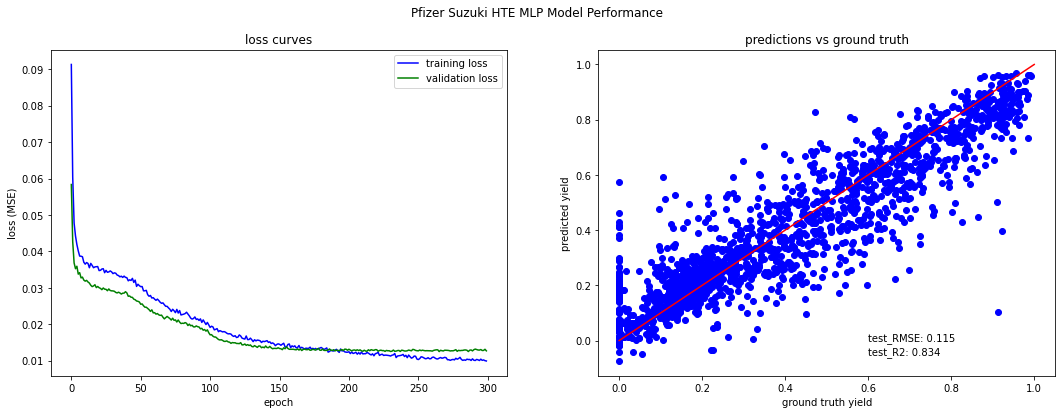

In [21]:
# Load model weights from best epoch
model.load_weights(checkpoint_filepath)

# Generate predictions for test set and measure test RMSE and R2
preds = model.predict(test_dataset)
evals = model.evaluate(x=test_dataset, return_dict=True)
r2 = r2_score(y_test, preds)
rmse = evals['root_mean_squared_error']
print(f'Test RMSE: {evals}')
print(f'Test R2: {r2}')

# Plot model performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle('Pfizer Suzuki HTE MLP Model Performance')

# Plot loss through training
ax1.plot(history.history['loss'], 'b', label='training loss')
ax1.plot(history.history['val_loss'], 'g', label='validation loss')
ax1.legend()
ax1.set_ylabel('loss (MSE)')
ax1.set_xlabel('epoch')
ax1.set_title('loss curves')

# Plot predictions vs ground truth
ax2.plot(y_test, preds, 'bo')
ax2.plot([0, 1], 'r')
ax2.set_ylabel('predicted yield')
ax2.set_xlabel('ground truth yield')
ax2.set_title('predictions vs ground truth')
ax2.text(0.6, 0, f'test_RMSE: {round(rmse, 3)}')
ax2.text(0.6, -0.05, f'test_R2: {round(r2, 3)}')

# Save and view performance plots
plt.savefig('ORD_Perera_HTE_yield_regression_MLP_performance.png', dpi=100)
plt.show()

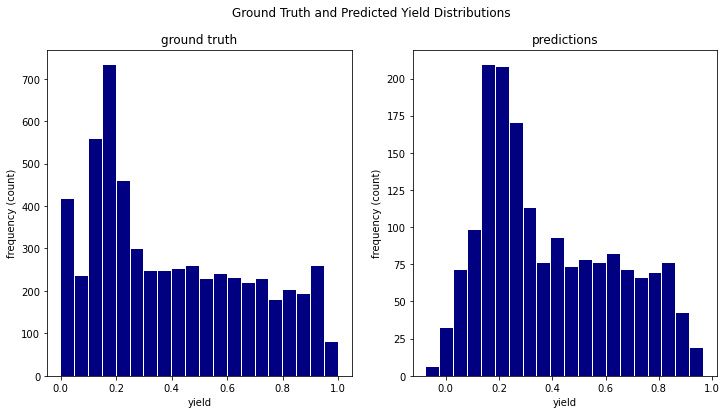

In [23]:
# Show ground truth and predicted yield distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Ground Truth and Predicted Yield Distributions')

# Plot ground truth histogram
ax1.hist(ohe_df['yield'], bins=20, rwidth=0.93, color='navy')
ax1.set_title('ground truth')
ax1.set_xlabel('yield')
ax1.set_ylabel('frequency (count)')

# Plot predicted histogram
ax2.hist(preds, bins=20, rwidth=0.93, color='navy')
ax2.set_title('predictions')
ax2.set_xlabel('yield')
ax2.set_ylabel('frequency (count)')

# Save and view distributions
plt.savefig('ORD_Perera_HTE_yield_regression_distributions.png', dpi=100)
plt.show()